In [1]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, text, union, union_all, literal

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = 'ce9a954f-a3c3-4784-b732-19f3fda31e2e'
IMPORT_ID = '56b6836e-b1e8-42ef-830f-742015a1d2fe'
SCHEME_ID = '1349896f-4fc3-4707-b995-b6992ef1e2ae'

In [2]:
df = pd.read_feather('../../data/beccs/predictions.arrow')
df_orig = pd.read_feather('../../data/beccs/predictions_orig.arrow')

In [3]:
df.head()

id                                       display_name  \
0  W998313739  CIUDEN experiences in CO 2 capture by oxycombu...   
1  W996081189  Renewable and Conventional Electricity Generat...   
2  W987537630  CFD modelling of co-firing of biomass with coa...   
3  W974774861  Strategic Sustainable Development for the Stat...   
4  W966484026  Reducing Carbon Emissions From Natural Gas-fir...   

                                               title  \
0  CIUDEN experiences in CO 2 capture by oxycombu...   
1  Renewable and Conventional Electricity Generat...   
2  CFD modelling of co-firing of biomass with coa...   
3  Strategic Sustainable Development for the Stat...   
4  Reducing Carbon Emissions From Natural Gas-fir...   

                                            abstract  \
0  One   of   the   most   relevant   European   ...   
1  In this chapter, the primary technical aspects...   
2  Co-firing biomass is the principal means of mi...   
3  An examination of the stationary power sector ...   
4  In this thesis, possibilities to reduce emissi...   

                                      title_abstract  \
0  CIUDEN experiences in CO 2 capture by oxycombu...   
1  Renewable and Conventional Electricity Generat...   
2  CFD modelling of co-firing of biomass with coa...   
3  Strategic Sustainable Development for the Stat...   
4  Reducing Carbon Emissions From Natural Gas-fir...   

                                         authorships  \
0  [{'author': {'display_name': 'Pedro Otero', 'i...   
1  [{'author': {'display_name': 'George Kosmadaki...   
2  [{'author': {'display_name': 'Arafat A. Bhuiya...   
3  [{'author': {'display_name': 'Lisa Chacón', 'i...   
4  [{'author': {'display_name': 'Erik Pihl', 'id'...   

                                           locations  is_retracted  \
0  [{'is_oa': False, 'is_primary': True, 'landing...         False   
1  [{'is_oa': False, 'is_primary': True, 'landing...         False   
2  [{'is_oa': False, 'is_primary': True, 'landing...         False   
3  [{'is_oa': False, 'is_primary': False, 'landin...         False   
4  [{'is_oa': False, 'is_primary': False, 'landin...         False   

  is_accepted  cited_by_count  is_paratext is_published language  \
0       False               0        False        False       en   
1       False              19        False        False       en   
2       False             133        False        False       en   
3       False               1        False        False       en   
4       False               0        False        False       en   

           type        mag  publication_year            _version_  \
0       article  998313739              2015  1792687275954405377   
1  book-chapter  996081189              2013  1792723741699997697   
2       article  987537630              2015  1792884794752761856   
3       article  974774861              2006  1792975134307385351   
4  dissertation  966484026              2012  1792929597459791875   

       publication_date          created_date              updated_date  \
0  2015-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-01-31T10:44:25.629Z   
1  2013-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-18T09:39:00.483Z   
2  2015-11-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-25T20:05:39.768Z   
3  2006-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-27T07:26:43.020Z   
4  2012-01-01T00:00:00Z  2016-06-24T00:00:00Z  2024-02-25T09:04:53.430Z   

   indexed_in                                          doi  \
0        None                                         None   
1  [crossref]  https://doi.org/10.1007/978-1-4471-5595-9_2   
2  [crossref]   https://doi.org/10.1016/j.fuel.2015.06.058   
3        None                                         None   
4        None                                         None   

                                              biblio  pmid pmcid  \
0                                               None  None  None   
1                                               N

In [4]:
with db_engine.session() as session:
    stmt_a = (
        select(AcademicItem.item_id, AcademicItem.openalex_id, literal(0).label('src'))
        .where(AcademicItem.openalex_id.in_(set(df['id'])), 
               AcademicItem.project_id == PROJECT_ID)
    )
    stmt_b = (
        select(AcademicItemVariant.item_id, AcademicItemVariant.openalex_id, literal(1).label('src'))
        .join(Item, and_(AcademicItemVariant.item_id == Item.item_id,
                         Item.project_id == PROJECT_ID))
        .where(AcademicItemVariant.openalex_id.in_(set(df['id'])))
    )
    # print(union(stmt_a, stmt_b))
    rslt = session.execute(union_all(stmt_a, stmt_b)).mappings().all()

    irslt = session.execute(select(m2m_import_item_table).where(m2m_import_item_table.c.import_id==IMPORT_ID)).mappings().all()
    item_ids = [str(r['item_id']) for r in irslt]

    erslt = session.execute(
        select(AcademicItem.item_id, AcademicItem.openalex_id)
        .where(AcademicItem.project_id == PROJECT_ID, AcademicItem.text == None)
    ).mappings().all()
    empty_item_ids = set([str(e['item_id']) for e in erslt])
    empty_openalex_ids = set([str(e['openalex_id']) for e in erslt])

rdf = pd.DataFrame(rslt)
mapping = {
    str(r['openalex_id']): str(r['item_id'])
    for _, r in rdf.iterrows()
}
imp_mapping = {
    k: v
    for k, v in mapping.items()
    if v in set(item_ids)
}

print('Number of items in df:', len(df))
print('Number of results:', len(rslt))
print(f'Number of items in project with missing abstract: {len(erslt):,} (unique item_ids: {len(empty_item_ids):,} / openalex_ids: {len(empty_openalex_ids):,})')
print(f'Size of mapping: {len(mapping):,} (keys) -> {len(set(mapping.values())):,} (values)')
print(f'Size of import mapping: {len(imp_mapping):,} (keys) -> {len(set(imp_mapping.values())):,} (values)')
print('Number of unique item_ids:', len(set(rdf['item_id'])))
print('Number of unique OA ids in result:', len(set(rdf['openalex_id'])))
print('Number of unique OA ids in result (0):', len(set(rdf[rdf['src']==0]['openalex_id'])))
print('Number of unique OA ids in result (1):', len(set(rdf[rdf['src']==1]['openalex_id'])))
print('Number of unique OA ids in df:',len(set(df['id'])))
print(f'Number of items in import: {len(irslt):,} (and unique item_ids: {len(set(item_ids)):,})')
print(f'Number of items in import without matching mapping: {len(set(item_ids) - set(mapping.values())):,}')
print(f'Number of items in import without matching import mapping: {len(set(item_ids) - set(imp_mapping.values())):,}')

Number of items in df: 2509
Number of results: 2598
Number of items in project with missing abstract: 131 (unique item_ids: 131 / openalex_ids: 131)
Size of mapping: 2,509 (keys) -> 2,392 (values)
Size of import mapping: 2,509 (keys) -> 2,392 (values)
Number of unique item_ids: 2392
Number of unique OA ids in result: 2509
Number of unique OA ids in result (0): 2392
Number of unique OA ids in result (1): 206
Number of unique OA ids in df: 2509
Number of items in import: 2,392 (and unique item_ids: 2,392)
Number of items in import without matching mapping: 0
Number of items in import without matching import mapping: 0


Review score is >=0.5: 588
Review is most confident method of all: 678


<Axes: >

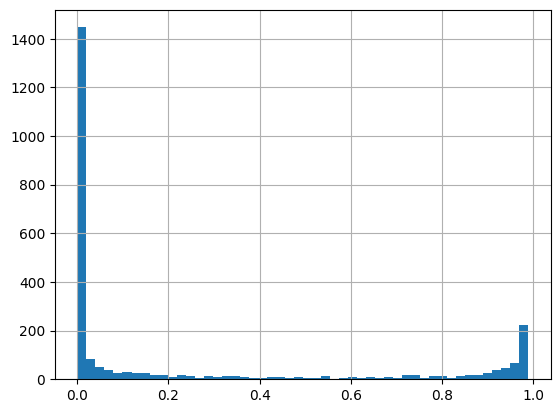

In [5]:
keys = ['meth|0', 'meth|1', 'meth|2', 'meth|3', 'meth|4', 'meth|5', 'meth|6', 'meth|7', 'meth|8', 'meth|9']
print('Review score is >=0.5:', (df['meth|5']>=0.5).sum())
print('Review is most confident method of all:', (df[keys].to_numpy().argmax(axis=1)==5).sum())
df['meth|5'].hist(bins=50)

In [6]:
mask_reviews = df[keys].to_numpy().argmax(axis=1) == 5
mask_import = df['id'].isin(imp_mapping.keys())
mask_abs = ~df['id'].isin(empty_openalex_ids)
mask = mask_reviews & mask_import & mask_abs
print(mask_import.sum(), mask_abs.sum(), mask_reviews.sum(), mask.sum())

2509 2378 678 659


In [7]:
a = [imp_mapping[i] for i in df[mask]['id']]
print(len(a), len(set(a)))

659 635


In [10]:
sample = df[mask].sample(n=20)
sample

id                                       display_name  \
253   W4377108190  Storing carbon dioxide for climate's sake: con...   
1735  W2767121944  Bioenergy With Carbon Capture and Storage (BECCS)   
1288  W3011505065  Removing Carbon Dioxide from the Air to Stabil...   
420   W4307664178  Opportunities for Producing Hydrogen and Low-c...   
1539  W2911393824  Energy and the New Reality 2: Carbon-free Ener...   
2132  W2123994082  Synergic and conflicting issues in planning un...   
358   W4313443577  Potential Technologies for Advanced Generation...   
1258  W3029781633  Comparing negative emissions and high renewabl...   
531   W4284707981  CAPTURING OF CARBON DI OXIDE AND PREVENTION OF...   
2175  W2087860495  Implications for the USA of stabilization of r...   
1777  W2746586112  Bridging critical anomalies and energy enginee...   
1801  W2667767773  Removing Harmful Greenhouse Gases from the Air...   
1806  W2626582129  The 1.5°C Target, Political Implications, and ...   
2242  W2044498032  Technoeconomic assessment of potential process...   
1578  W2898063522  Investigating the BECCS resource nexus: delive...   
277   W4366455299  A green route for hydrogen production from alk...   
914   W3185944470  Towards Sustainable Oxalic Acid from CO<sub>2<...   
2380  W1978738327    The current status of CCS development in Brazil   
2314  W2006637253  Waste materials for carbon capture and storage...   
2286  W2022018300  A comparative global assessment of potential n...   

                                                  title  \
253   Storing carbon dioxide for climate's sake: con...   
1735  Bioenergy With Carbon Capture and Storage (BECCS)   
1288  Removing Carbon Dioxide from the Air to Stabil...   
420   Opportunities for Producing Hydrogen and Low-c...   
1539  Energy and the New Reality 2: Carbon-free Ener...   
2132  Synergic and conflicting issues in planning un...   
358   Potential Technologies for Advanced Generation...   
1258  Comparing negative emissions and high renewabl...   
531   CAPTURING OF CARBON DI OXIDE AND PREVENTION OF...   
2175  Implications for the USA of stabilization of r...   
1777  Bridging critical anomalies and energy enginee...   
1801  Removing Harmful Greenhouse Gases from the Air...   
1806  The 1.5°C Target, Political Implications, and ...   
2242  Technoeconomic assessment of potential process...   
1578  Investigating the BECCS resource nexus: delive...   
277   A green route for hydrogen production from alk...   
914   Towards Sustainable Oxalic Acid from CO<sub>2<...   
2380    The current status of CCS development in Brazil   
2314  Waste materials for carbon capture and storage...   
2286  A comparative global assessment of potential n...   

                                               abstract  \
253   An increase in carbon capture and storage (CCS...   
1735  BECCS (bioenergy with carbon capture and stora...   
1288  Forests, wetlands, peatlands and coastal habit...   
420   Abstract Venezuela has a big potential for the...   
1539  Transforming our energy supplies to be more su...   
2132  In densely populated countries there is a grow...   
358   Biofuels are quickly emerging as a way to “mod...   
1258  Abstract Emerging literature highlights the es...   
531   The generation of heat, electricity is being p...   
2175  Stabilization presents a daunting challenge fo...   
1777  Near-critical and supercritical fluids, in par...   
1801  Carbon dioxide (written as CO2) releases from ...   
1806  The 2°C target for global warming had been und...   
2242  The use of biomass in the production of plasti...   
1578  BECCS performance can be measured by a wide ra...   
277   Hydrogen, a green energy carrier, is one of th...   
914   To quickly and drastically reduce CO2 emission...   
2380  The IEA CCS Roadmap highlighted the significan...   
2314  This work reviews the advantages and disadvant...   
2286  The paper summarises a global assessment of ar...   

                      

In [12]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

name = '20240716_testing_all'
description = '20 random documents assigned to all (conditions predicted as review, has abstract, in import "openalex snapshot 2024-06-17")'

users = [
    #('54304db8-a766-4cf5-a6e7-6f16ecb09c9d', 'ingrid.schulte'),
    # ('fd641232-bada-466e-9a3b-fb12038f5508', 'tim.repke'),
    ('ddbf75cf-0a8e-4e24-97c6-4111ad13bb60', 'daniela.thraen'),
    ('db92716c-874d-44be-be4c-0cefe52ee7e9', 'piera.patrizio'),
    ('f680e9a5-ae6e-4623-afa0-536208f78442', 'mai.bui'),
    ('c2d00541-6279-43f8-a10a-1058c28195ed', 'caroline.lichtmann'),
    ('fc015a21-018a-4732-91db-977fad0c3ddc', 'nir.reshef'),
    ('c91e862f-95bf-48d9-a9f6-a61c41caf7ce', 'matthew.wilks'),
    ('d21bb711-4e73-4eb1-83ad-890efb073162', 'tanvi.sharma'),
    ('3b23bd67-787c-430f-930c-88c22b13ad38', 'paola.cavazos'),
    ('79cd0b1a-e8a2-48c4-b5d3-b00c2214a40d', 'mathias.fridahl'),
    ('e2020f0f-8f0a-411c-a14c-5dbe2a6ab3c0', 'malgorzata.borchers'),
]

with db_engine.session() as session:
    scope_id = str(uuid.uuid4())
    print(f'Creating scope with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=name,
            description=description
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, oa_id in enumerate(sample['id']):
        item_id = imp_mapping[oa_id]
        print(f'#{di + 1}/{len(sample)} | Creating assignments for {oa_id} -> {item_id}')
        for user_id, username in users:
            assi_id = uuid.uuid4()

            if not DRY_RUN:
                assi = Assignment(assignment_id=assi_id,
                                  assignment_scope_id=scope_id,
                                  user_id=user_id,
                                  item_id=item_id,
                                  annotation_scheme_id=SCHEME_ID,
                                  status=AssignmentStatus.OPEN,
                                  order=di)
                session.add(assi)
                session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')
    print(f'Created {cnt} assignments!')
    

Creating scope with ID c0b4cad3-0686-4239-8fa7-db7a1f65d168
#1/20 | Creating assignments for W4377108190 -> e61fa611-9d38-4174-baa2-214c23f4feca
  -> daniela.thraen via 1e12f3fb-1674-4c69-9b77-afaa6140b575 for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> piera.patrizio via 20c46474-cbb9-4d51-9aa1-886747ec0028 for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> mai.bui via e6603658-4926-4767-b42a-13f07ea72c56 for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> caroline.lichtmann via 5ce802ac-4330-4cdd-af95-7d19f0f80dff for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> nir.reshef via 715d2f6a-1e39-48e4-b2d0-1dbc596fc25e for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> matthew.wilks via 35439d40-7abe-49e2-8d77-17cc9d056b98 for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> tanvi.sharma via 4aa6ffba-6b2b-4022-8522-628e364f1674 for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  -> paola.cavazos via 4fda130a-019f-45c0-b476-77918c9a52cb for scope c0b4cad3-0686-4239-8fa7-db7a1f65d168
  

In [13]:
with db_engine.session() as session:
    r = session.execute(text('''
    SELECT u.user_id, u.username
    FROM project_permissions pm
    JOIN "user" u ON pm.user_id=u.user_id
    WHERE pm.project_id = :pid
    '''), {'pid': PROJECT_ID}).mappings().all()
    for ri in r:
        print(f"('{ri['user_id']}', '{ri['username']}'),")

('54304db8-a766-4cf5-a6e7-6f16ecb09c9d', 'ingrid.schulte'),
('ddbf75cf-0a8e-4e24-97c6-4111ad13bb60', 'daniela.thraen'),
('db92716c-874d-44be-be4c-0cefe52ee7e9', 'piera.patrizio'),
('f680e9a5-ae6e-4623-afa0-536208f78442', 'mai.bui'),
('c2d00541-6279-43f8-a10a-1058c28195ed', 'caroline.lichtmann'),
('fc015a21-018a-4732-91db-977fad0c3ddc', 'nir.reshef'),
('c91e862f-95bf-48d9-a9f6-a61c41caf7ce', 'matthew.wilks'),
('d21bb711-4e73-4eb1-83ad-890efb073162', 'tanvi.sharma'),
('3b23bd67-787c-430f-930c-88c22b13ad38', 'paola.cavazos'),
('e2020f0f-8f0a-411c-a14c-5dbe2a6ab3c0', 'malgorzata.borchers'),
('79cd0b1a-e8a2-48c4-b5d3-b00c2214a40d', 'mathias.fridahl'),
